In [2]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.optimize import curve_fit

C:\Users\ricca\AppData\Local\Temp\ipykernel_14740\2119030599.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
KB = c.Boltzmann
hbar = c.Planck

In [4]:
def QT(T,d0, q0, alpha, omega):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, q0, alpha, omega, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

def retta(x, m, q):
    return m*x + q

def resonance(x, x0, Q, Q_c, phi0):
    num = np.exp(1j*phi0)
    den = 1 + 2*1j*Q*(x-x0)/x0
    return abs(1 - (Q/Q_c)*(num/den))

def model(x,m,q,x0,Q,Q_c,phi0):
    return retta(x,m,q) * resonance(x,x0,Q,Q_c,phi0)

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = max(y) - (max(y)-min(y)) / 2.
    minimums = x[np.where(y < half)]
    if len(minimums)==0: 
        print('Minimum not found!')
        return 0,1
    else:
        return (max(minimums) - min(minimums)),0

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def compute_chi2(func,x, y, sigma, p):
    sum = 0
    for (i,j,s) in zip(x,y,sigma):
        sum += ((j-func(i,*p))/s)**2
    return sum





def plotter(dfs, t, func, p, c, rows, columns, fill):

    fig, ax = plt.subplots(rows, columns, figsize=(30,20))

    for row in range(rows):
        for col in range(columns):
            i = row*columns + col


            chi2 = compute_chi2(func, np.array(dfs[i]['f']),np.array(dfs[i]['S21']), np.array(dfs[i]['S21'])*1e-3, p[i])
            ndof = len(dfs)
            title = [
                f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
            ]

            for (l,value) in enumerate(p[i]):
                title.append(
                    f"{value:.4f} +/- {np.diag(c[i])[l]:.4f}"
                )


            ax[row][col].scatter(np.array(dfs[i]['f'])*1e-9, np.array(dfs[i]['S21']), marker='.', s=1, label='Raw Data', color='black')
            ax[row][col].plot(np.array(dfs[i]['f'])*1e-9, func(np.array(dfs[i]['f']), *p[i]), label='Model', color='red')
            if (fill==True):
                ax[row][col].fill_between(np.array(dfs[i]['f'])*1e-9, np.array(dfs[i]['S21'])*(1-(1e-3)), np.array(dfs[i]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            ax[row][col].set_facecolor('bisque')
            ax[row][col].set_xlabel(r'$\nu$ [GHz]')
            ax[row][col].set_ylabel(r'$|S_{21}|$')
            ax[row][col].legend(title='\n'.join(title))
            ax[row][col].set_title('T: '+str(t[i]))
            ax[row][col].grid()
            fig.tight_layout()

    return fig

def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set1\\'):

    dfs, dictionaries = [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            parent = dir+folder+'\\'
            dictionaries = []
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as r:
                    group = r.require_group(name='raw_data')
                    dic = dict()
                    for c in group.items():
                        dic[c[0]] = c[1][:]
                dictionaries.append(dic)
        dfs.append(dictionaries)
    return dfs

In [6]:
dfs = read_files() 

In [8]:
migrads, pars = [], []
for i in range(12):
    for j in range(4):
        dfs[i][j]['S21'] = 20*np.log10(np.sqrt(np.array(dfs[i][j]['i'])**2 + np.array(dfs[i][j]['q'])**2))
        width,_ = FWHM(np.array(dfs[i][j]['f']),(np.array(dfs[i][j]['S21'])))
        stima_x0 = float(np.array(dfs[i][j]['f'])[np.where(np.array(dfs[i][j]['S21']) == np.min(np.array(dfs[i][j]['S21'])))[0]])
        stima_Q = float(Q_stima(stima_x0,width))
        stima_m = float(((np.array(dfs[i][j]['S21']))[0]-(np.array(dfs[i][j]['S21']))[-1])/(np.array(dfs[i][j]['f'])[0]-np.array(dfs[i][j]['f'])[-1]))
        stima_q = (np.array(dfs[i][j]['S21']))[0] - stima_m * (np.array(dfs[i][j]['f']))[0]
        stima_Q_c = 10600
        stima_phi = 0.2
        pars.append([stima_m, stima_q, stima_x0, stima_Q, stima_Q_c, stima_phi])

C:\Users\ricca\AppData\Local\Temp\ipykernel_14740\3607863292.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stima_x0 = float(np.array(dfs[i][j]['f'])[np.where(np.array(dfs[i][j]['S21']) == np.min(np.array(dfs[i][j]['S21'])))[0]])


In [9]:
temps = np.arange(50, 290, 20)

In [10]:
m2, temps2, dfs2, popts, pcovs = [], [], [], [], []
for i in range(len(dfs)):
    for k in range(4):
        try:
            #bounds = np.array([(0,0), (-np.inf,np.inf), (-np.inf,np.inf), (0,np.inf), (0,np.inf),(0,1)])
            popt, pcov = curve_fit(model, dfs[i][j]['f'], dfs[i][j]['S21'], p0=pars[i*4+j])#, bounds=bounds, maxfev=10000)
            temps2.append(temps[i*4+j]*1e-3)
            popts.append(popt)
            pcovs.append(pcov)
            dfs2.append(dfs[i])
        except:
            pass

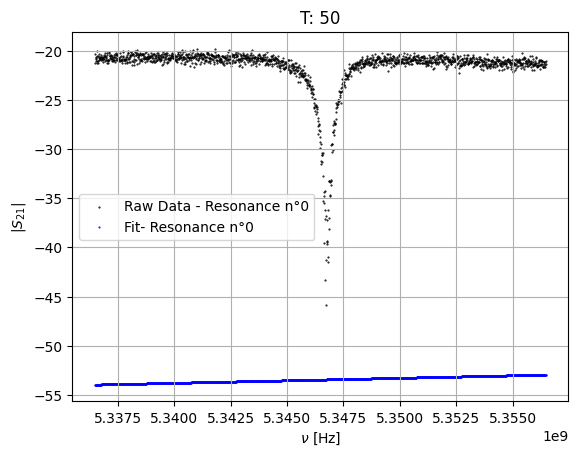

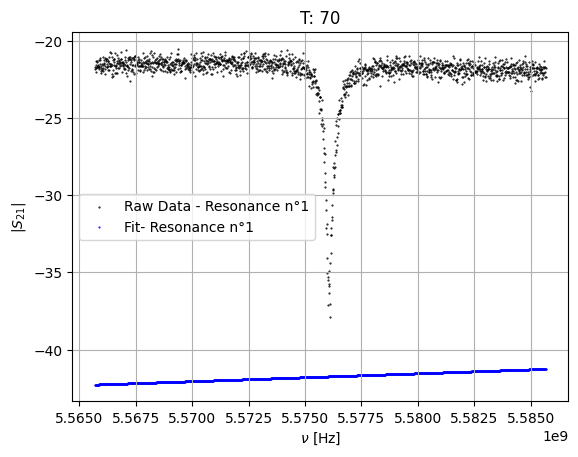

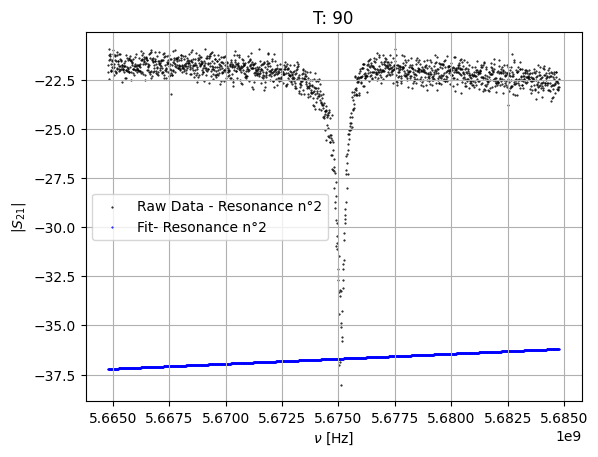

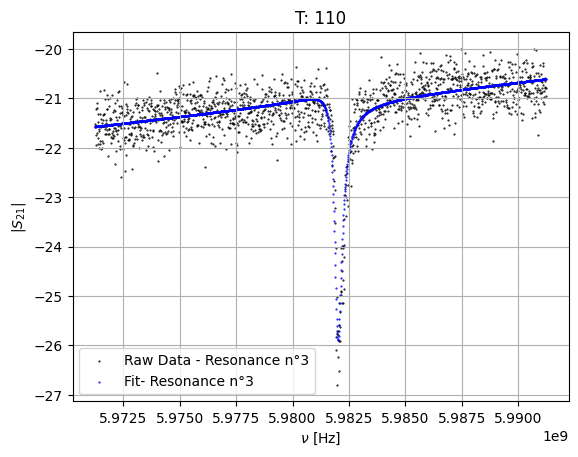

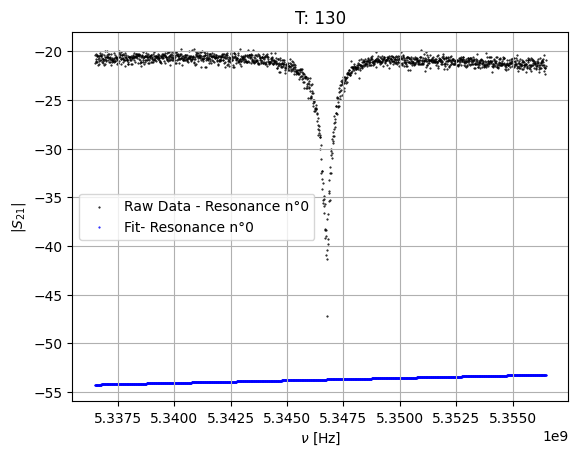

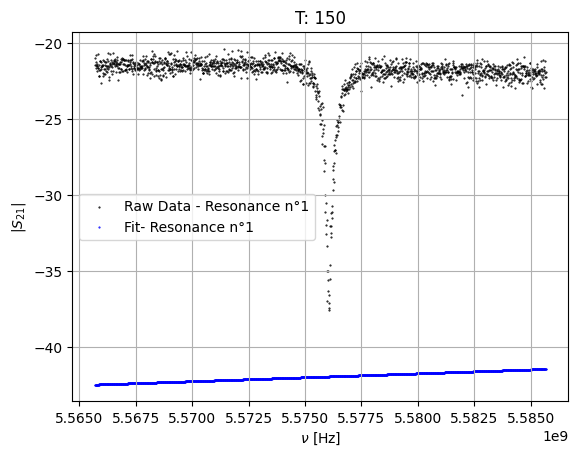

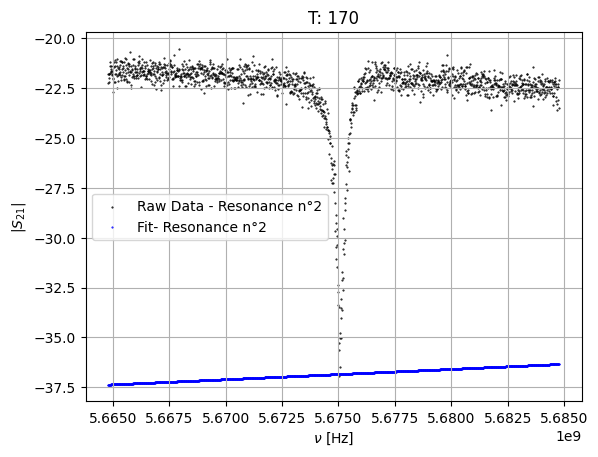

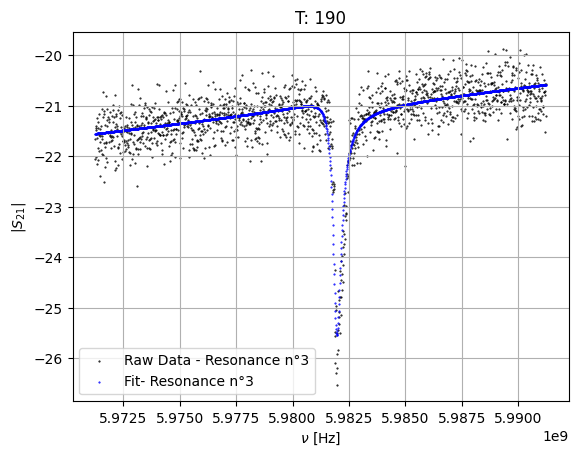

IndexError: list index out of range

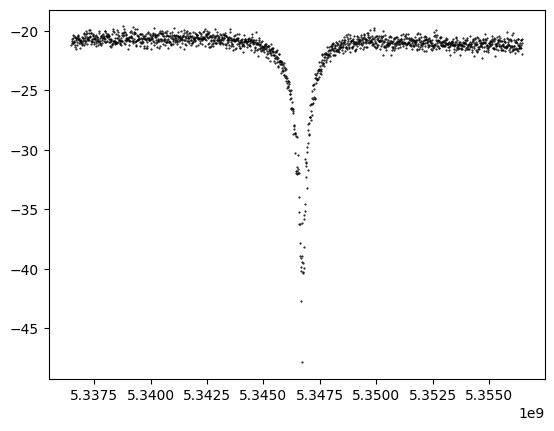

In [13]:
for i in range(len(dfs)):
    for j in range(4):
        plt.scatter(dfs[i][j]['f'], dfs[i][j]['S21'], marker='.', color='black', s=1, label='Raw Data - Resonance n°'+str(j))
        plt.scatter(dfs[i][j]['f'], model(dfs[i][j]['f'], *popts[i*4+j]), marker='.', s=1, color='blue', label='Fit- Resonance n°'+str(j))
        plt.xlabel(r'$\nu$ [Hz]')
        plt.ylabel(r'$|S_{21}|$')
        plt.legend()
        plt.grid()
        plt.title('T: '+str(temps[i*4+j]))
        plt.show()

In [54]:
x,y = [], []
for i in range(len(m2)):
    y.append(m2[i].values[2]/1e9)
    x.append(temps2[i])
x = np.array(x)
y = np.array(y)

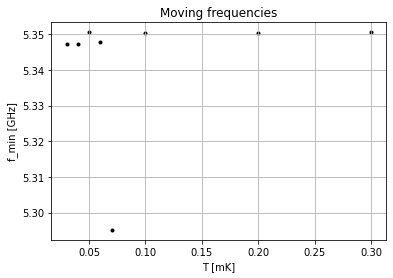

In [9]:
plt.scatter(x,y, marker='.',color='black')
plt.xlabel('T [mK]')
plt.ylabel('f_min [GHz]')
#plt.ylim([3.1774,3.1778])
plt.title('Moving frequencies')
plt.grid()

Let's create a new file with $\frac{1}{Q}$, T and $\sigma_{T}$

In [10]:
Q_invs,Q_invs_err,Qs = [], [], []
for i in range(len(temps2)):
    Qs.append(m2[i].values['Q'])
    Q_invs.append(1/(m2[i].values['Q']))
    Q_invs_err.append(1/m2[i].values['Q']**2 * m2[i].errors['Q'])
Q_invs = np.array(Q_invs)
Q_invs_err = np.array(Q_invs_err)
new_temp2 = np.array(temps2)
datas = {'T':new_temp2,'1/Q':Q_invs,'1/Q_err':Q_invs_err}
dataframe = pd.DataFrame(data=datas)
dataframe.to_csv('Fitted.csv',sep='\t',index=False)